# Generación de un modelo con capas de normalización por lotes
---
**Configuración General del Entorno de Trabajo**

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [42]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:     
    # configuración para notebook en COLAB
    DRIVE_DIR = '/content/drive/MyDrive/' # carpeta G-Drive
    MNT_DRIVE_DIR = '/content/drive/'     # carpeta donde montar G-Drive
    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/Fuentes' 
    DATOS_DIR = DRIVE_DIR + 'Datos/'      # carpeta donde se encuentran los datasets

    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount(MNT_DRIVE_DIR)
else:
    # configuración para notebook con instalación LOCAL
    
    
    FUENTES_DIR = './RN2022/Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR = 'D:/Internet/G-Drive/Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

---
**Preparación de Dataset**

Para poder trabajar con el dataset se debe:
1. Copiar los archivos FlowersX16.7z.001 y FlowersX16.7z.002 en la carpeta drive de los datos (establecida para este script en DATOS_DIR).
2. Ubicar el directorio actual en la misma carpeta
3. Descomprimir con 7zip los archivos

In [43]:
# Los archivos FlowersX16.7z.001 y FlowersX16.7z.002 deben estar en la carpeta
# para descomprimir las imagenes con el compresor 7zip
# !7z x "/content/drive/MyDrive/Datos/FlowersX16.7z.001" -o"/content/drive/MyDrive/Datos/"

**Preparación de Datos**

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from ClassEpochTiming import EpochTiming


# constantes para arquitectura, generación datos y entrenamiento/validacion
IMG_SIZE = (96, 96, 3)  # tamaño de la imagen de entrada
N_CLASSES = 16          # cantidad de clases a identificar
LOTES = 128             # tamaño de lotes para entrenamiento y testeo 
ALFA = 0.01             # tasa de entrenamiento
EPOCAS = 1000           # cantidad de epocas a entrenar como máximo
PACIENCIA = 10          # parámetro para parada temprana
SEP_TRAIN_TEST = 0.2    # división en entrenamiento y validación 


IMAGES_DIR = DATOS_DIR + 'FlowersX16'

# construye un generador de imagenes para dividir en entrenamiento y validación
data_generator = ImageDataGenerator(
    validation_split=SEP_TRAIN_TEST,
    rescale= 1.0/255,
    zoom_range=0.15,  # (0.8,1.0),         # zoom
    width_shift_range=0.2,   # desplazamiento horizontal
    height_shift_range=0.2,  # desplazamiento vertical
    horizontal_flip=True,   # espejo horizontal
    brightness_range=(0.8, 1.2) # brillo
)

# generador para entrenamiento a partir de la carpeta indicada en IMAGES_DIR
train_iter = data_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=IMAGES_DIR, 
            class_mode='categorical',
            batch_size=LOTES,
            subset='training'   # asigna subconjunto segun validation_split del ImageDataGenerator
            )

valid_iter = data_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=IMAGES_DIR, 
            class_mode='categorical',
            batch_size=LOTES,
            subset='validation' # asigna subconjunto segun validation_split del ImageDataGenerator
            )

Found 12599 images belonging to 16 classes.
Found 3141 images belonging to 16 classes.


**Construcción del Modelo**

In [45]:
ACTIVATION = 'LeakyReLU'

# %% construye le modelo
def build_model(img_size, classes):

    model = Sequential()

    model.add(Conv2D(8, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, input_shape=img_size)) 
    model.add(MaxPooling2D(pool_size=(2,2)))  
    #model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION)) 
    model.add(MaxPooling2D(pool_size=(2,2)))    
    #model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION)) 
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION)) 
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION)) 
    model.add(MaxPooling2D(pool_size=(2,2)))    
    #model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(100, activation = 'LeakyReLU'))
    model.add(BatchNormalization())
    model.add(Dense(100, activation = 'LeakyReLU'))
    model.add(BatchNormalization())
    model.add(Dense(classes, activation = 'softmax'))

    model.summary()
    return model


# %% construye le modelo
# obtiene la arquitectura para el modelo y lo compila
model = build_model(IMG_SIZE, N_CLASSES)
model.compile('adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model.compile('RMSProp', loss = 'categorical_crossentropy', metrics = ['accuracy'])



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 94, 94, 8)         224       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 47, 47, 8)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 45, 45, 16)        1168      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 64)         

Epoch 1/1000
99/99 [==============================] - 59s 581ms/step - loss: 1.9247 - accuracy: 0.3491 - val_loss: 2.6136 - val_accuracy: 0.1328
Epoch 2/1000
99/99 [==============================] - 43s 439ms/step - loss: 1.5486 - accuracy: 0.4746 - val_loss: 2.3436 - val_accuracy: 0.2090
Epoch 3/1000
99/99 [==============================] - 46s 463ms/step - loss: 1.3677 - accuracy: 0.5370 - val_loss: 1.9481 - val_accuracy: 0.3955
Epoch 4/1000
99/99 [==============================] - 52s 523ms/step - loss: 1.2567 - accuracy: 0.5772 - val_loss: 1.6311 - val_accuracy: 0.5049
Epoch 5/1000
99/99 [==============================] - 53s 535ms/step - loss: 1.1767 - accuracy: 0.6055 - val_loss: 1.5173 - val_accuracy: 0.4658
Epoch 6/1000
99/99 [==============================] - 53s 531ms/step - loss: 1.1213 - accuracy: 0.6193 - val_loss: 1.4046 - val_accuracy: 0.5410
Epoch 7/1000
99/99 [==============================] - 59s 598ms/step - loss: 1.0708 - accuracy: 0.6397 - val_loss: 1.3819 - val_ac

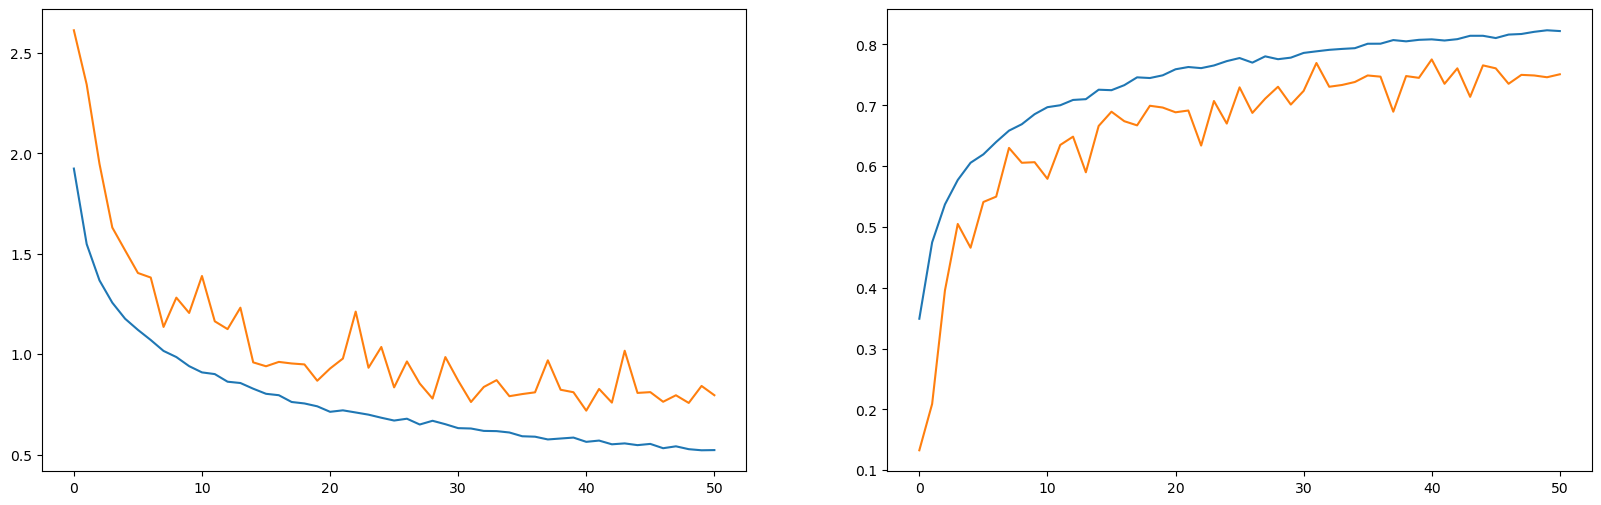

<Figure size 640x480 with 0 Axes>

In [46]:
# %% Entrenamiento del modelo 

# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PACIENCIA,  
                           restore_best_weights=True)

epoch_timing = EpochTiming()

H = model.fit(
    train_iter,
    validation_data=valid_iter,
    validation_steps= 8,
    epochs=EPOCAS,
    callbacks=[early_stop, epoch_timing])

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

In [47]:
#print('Tiempo promedio por época %.2f segundos' % epoch_timing.avg_epoch_time)
model.evaluate(train_iter)
model.evaluate(valid_iter)

25/25 [==============================] - 14s 551ms/step - loss: 0.7465 - accuracy: 0.7644


[0.7464852333068848, 0.7644062638282776]